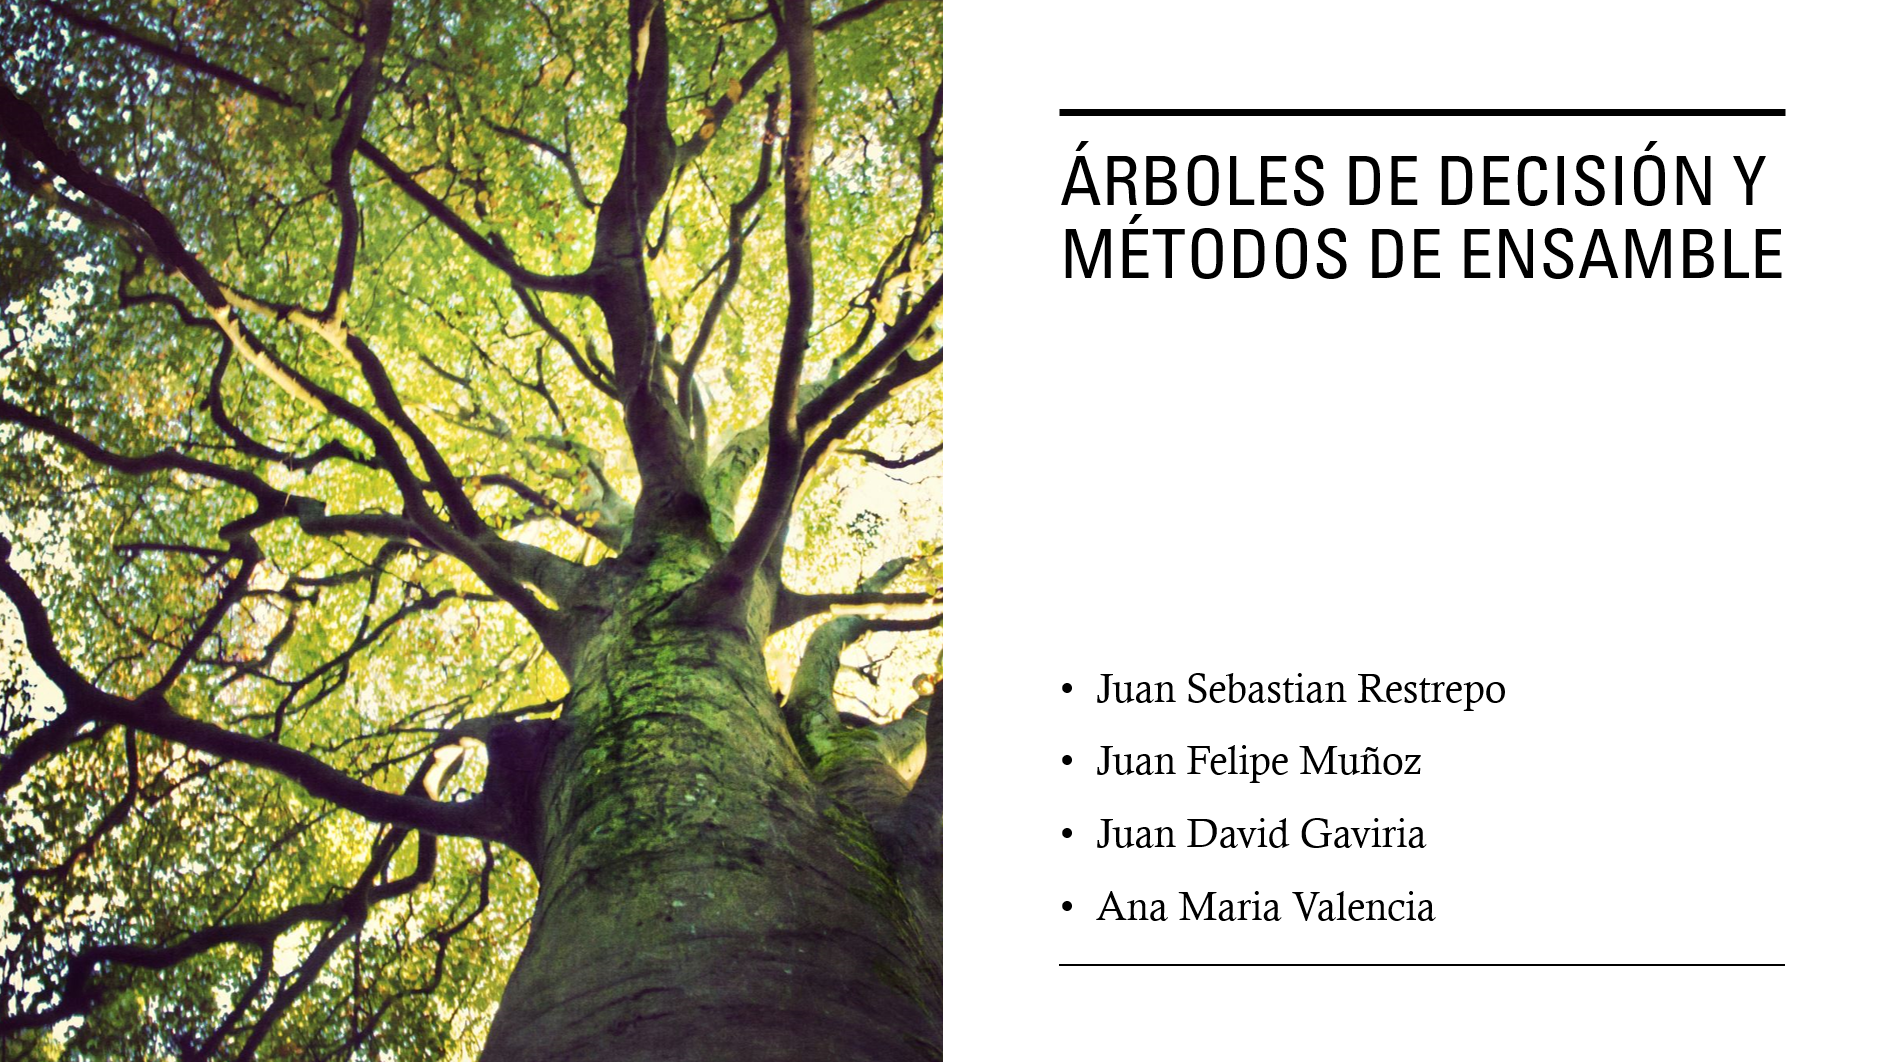

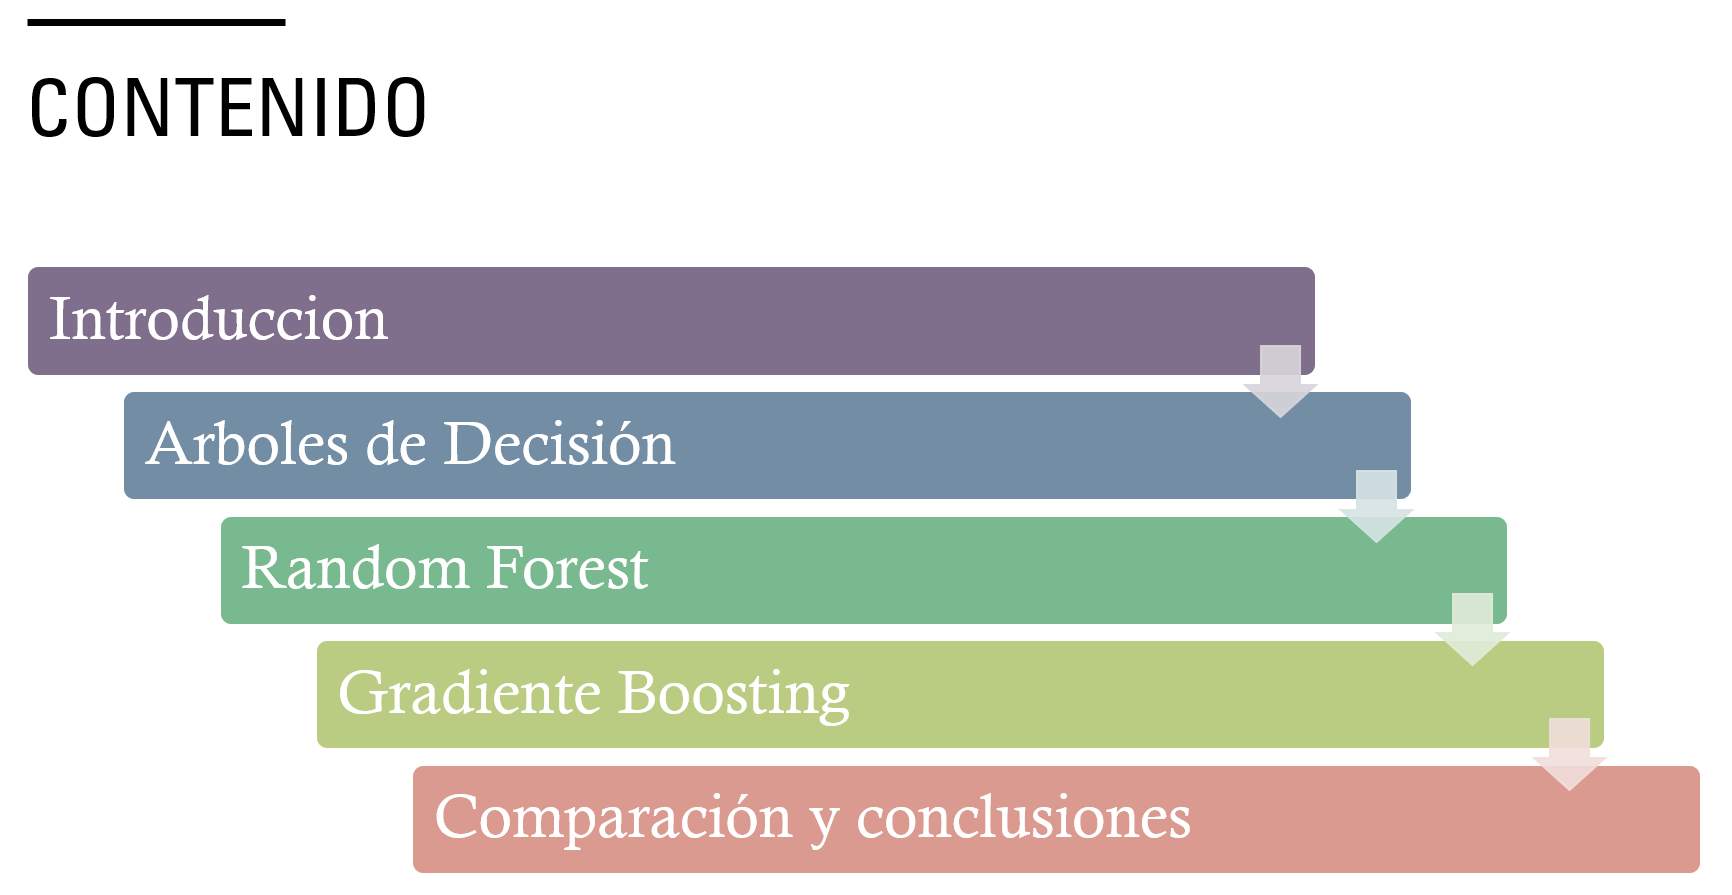

### Instalacion librerias
**Solo correr una vez si es local, si es en Colab siempre ejecuta**

In [61]:
# Solo correr una vez si es local, si es en Colab siempre ejecutar
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost jupyter

### Importar Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Carga y Preparación de Datos

## 1.1 Titanic Dataset

La base de datos proporcionada corresponde al famoso conjunto de datos del Titanic, utilizado comúnmente para practicar y evaluar modelos de aprendizaje automático supervisado. Este dataset contiene información sobre los pasajeros del Titanic, incluyendo características como el género, la clase del boleto, la edad y otros datos relevantes que pueden ayudar a predecir si un pasajero sobrevivió o no al hundimiento del barco.

In [2]:

titanic = pd.read_csv('titanic.csv')

print(f"Titanic dataset shape: {titanic.shape}")
titanic.head()

Titanic dataset shape: (891, 12)


PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

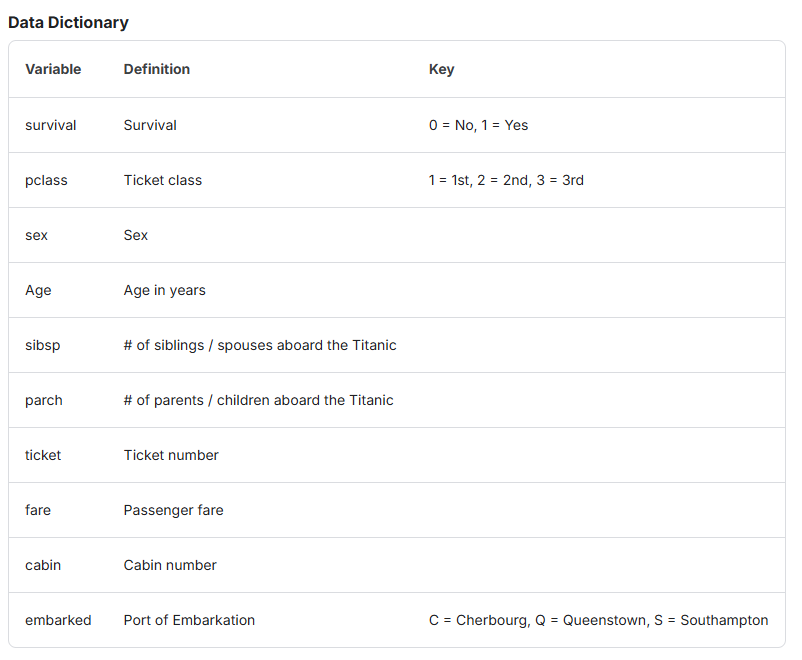

In [3]:
# Preprocesamiento Titanic
def preprocess_titanic(df):
    df = df.copy()

    # Eliminar columnas no necesarias
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    # Imputar valores faltantes
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True) # puerto mas frecuente de embarque
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    # Codificar variables categóricas
    le = LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Embarked'] = le.fit_transform(df['Embarked'])

    return df

titanic_clean = preprocess_titanic(titanic)
print("Titanic dataset después del preprocesamiento:")
print(titanic_clean.info())

Titanic dataset después del preprocesamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB
None


In [4]:
# Preparar variables para Titanic
X_titanic = titanic_clean.drop('Survived', axis=1)
y_titanic = titanic_clean['Survived']

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_titanic, y_titanic, test_size=0.2, random_state=42, stratify=y_titanic
)

print(f"Titanic - Train shape: {X_train_t.shape}, Test shape: {X_test_t.shape}")

Titanic - Train shape: (712, 7), Test shape: (179, 7)


## 1.2 Bank Marketing Dataset

La base de datos corresponde a una serie de campañas de marketing directo realizadas por una institución bancaria portuguesa, cuyo objetivo era promocionar la suscripción de depósitos a plazo **(CDT)**. Estas campañas se llevaron a cabo mediante llamadas telefónicas, y en muchos casos fue necesario contactar a los mismos clientes varias veces para determinar su interés en el producto.

In [5]:
bank = pd.read_csv('bank.csv', sep=';')
print("Bank dataset cargado desde archivo local")

print(f"Bank Marketing dataset shape: {bank.shape}")
bank.head()

Bank dataset cargado desde archivo local
Bank Marketing dataset shape: (4521, 17)


age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

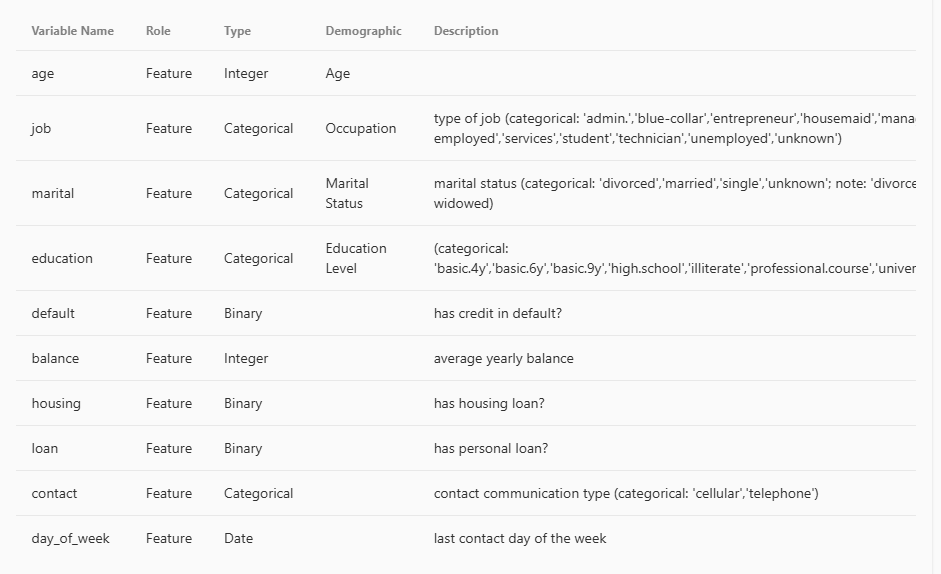
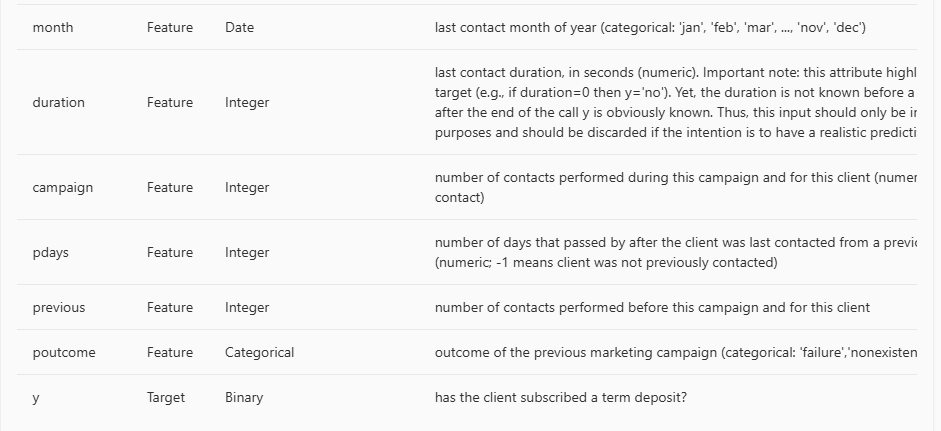

In [6]:
# Preprocesamiento Bank Marketing
def preprocess_bank(df):
    df = df.copy()

    # Codificar variable objetivo
    df['y'] = df['y'].map({'yes': 1, 'no': 0})

    # Codificar variables categóricas
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    return df

bank_clean = preprocess_bank(bank)
print("Bank Marketing dataset después del preprocesamiento:")
print(bank_clean.info())

Bank Marketing dataset después del preprocesamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   int64
 2   marital    4521 non-null   int64
 3   education  4521 non-null   int64
 4   default    4521 non-null   int64
 5   balance    4521 non-null   int64
 6   housing    4521 non-null   int64
 7   loan       4521 non-null   int64
 8   contact    4521 non-null   int64
 9   day        4521 non-null   int64
 10  month      4521 non-null   int64
 11  duration   4521 non-null   int64
 12  campaign   4521 non-null   int64
 13  pdays      4521 non-null   int64
 14  previous   4521 non-null   int64
 15  poutcome   4521 non-null   int64
 16  y          4521 non-null   int64
dtypes: int64(17)
memory usage: 600.6 KB
None


In [7]:
# Preparar variables para Bank Marketing
X_bank = bank_clean.drop('y', axis=1)
y_bank = bank_clean['y']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bank, y_bank, test_size=0.2, random_state=42, stratify=y_bank
)

print(f"Bank Marketing - Train shape: {X_train_b.shape}, Test shape: {X_test_b.shape}")

Bank Marketing - Train shape: (3616, 16), Test shape: (905, 16)


# 2. Árboles de Decisión

## 2.1 Implementación Básica

In [69]:
# Árbol de decisión para Titanic
dt_titanic = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_titanic.fit(X_train_t, y_train_t)

y_pred_t = dt_titanic.predict(X_test_t)
accuracy_t = accuracy_score(y_test_t, y_pred_t)

print(f"Árbol de Decisión - Titanic - Accuracy: {accuracy_t:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_t, y_pred_t))

Árbol de Decisión - Titanic - Accuracy: 0.7933

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       110
           1       0.86      0.55      0.67        69

    accuracy                           0.79       179
   macro avg       0.82      0.75      0.76       179
weighted avg       0.81      0.79      0.78       179



Matriz de Confusión:
[[104   6]
 [ 31  38]]


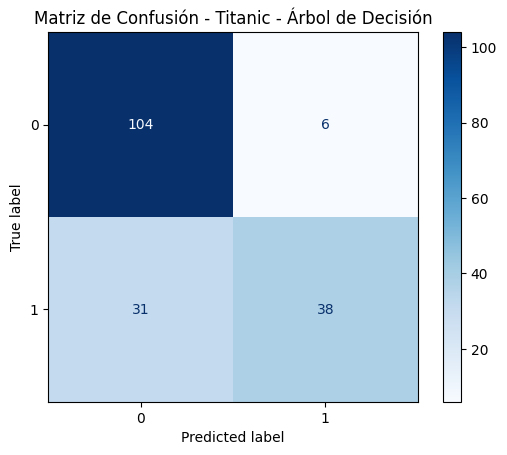

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Crear la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred_t)

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(cm)

# Visualizar la matriz de confusión de forma gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_titanic.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Titanic - Árbol de Decisión')
plt.show()

El modelo acierta muy bien al decir quién no sobrevivió, pero le cuesta un poco más reconocer a las personas que sí sobrevivieron. En otras palabras, tiende a ser conservador: prefiere decir que alguien murió, aunque se equivoque en algunos casos

In [13]:
# Árbol de decisión para Bank Marketing
dt_bank = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_bank.fit(X_train_b, y_train_b)

y_pred_b = dt_bank.predict(X_test_b)
accuracy_b = accuracy_score(y_test_b, y_pred_b)

print(f"Árbol de Decisión - Bank Marketing - Accuracy: {accuracy_b:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_b, y_pred_b))

Árbol de Decisión - Bank Marketing - Accuracy: 0.8851

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       801
           1       0.50      0.27      0.35       104

    accuracy                           0.89       905
   macro avg       0.71      0.62      0.64       905
weighted avg       0.86      0.89      0.87       905



Matriz de Confusión - Bank Marketing:
[[773  28]
 [ 76  28]]


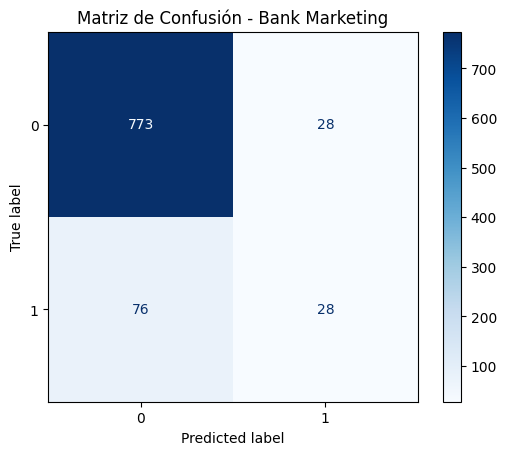

In [72]:
# Crear la matriz de confusión
cm_b = confusion_matrix(y_test_b, y_pred_b)

# Mostrar la matriz de confusión en consola
print("Matriz de Confusión - Bank Marketing:")
print(cm_b)

# Visualizar la matriz de confusión
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b, display_labels=dt_bank.classes_)
disp_b.plot(cmap='Blues')
plt.title('Matriz de Confusión - Bank Marketing')
plt.show()

Pasa algo parecido al dataset del titanic.
Esto suele pasar cuando el dataset está desbalanceado (hay muchos más "no" que "sí").

## 2.2 Visualización de Árboles

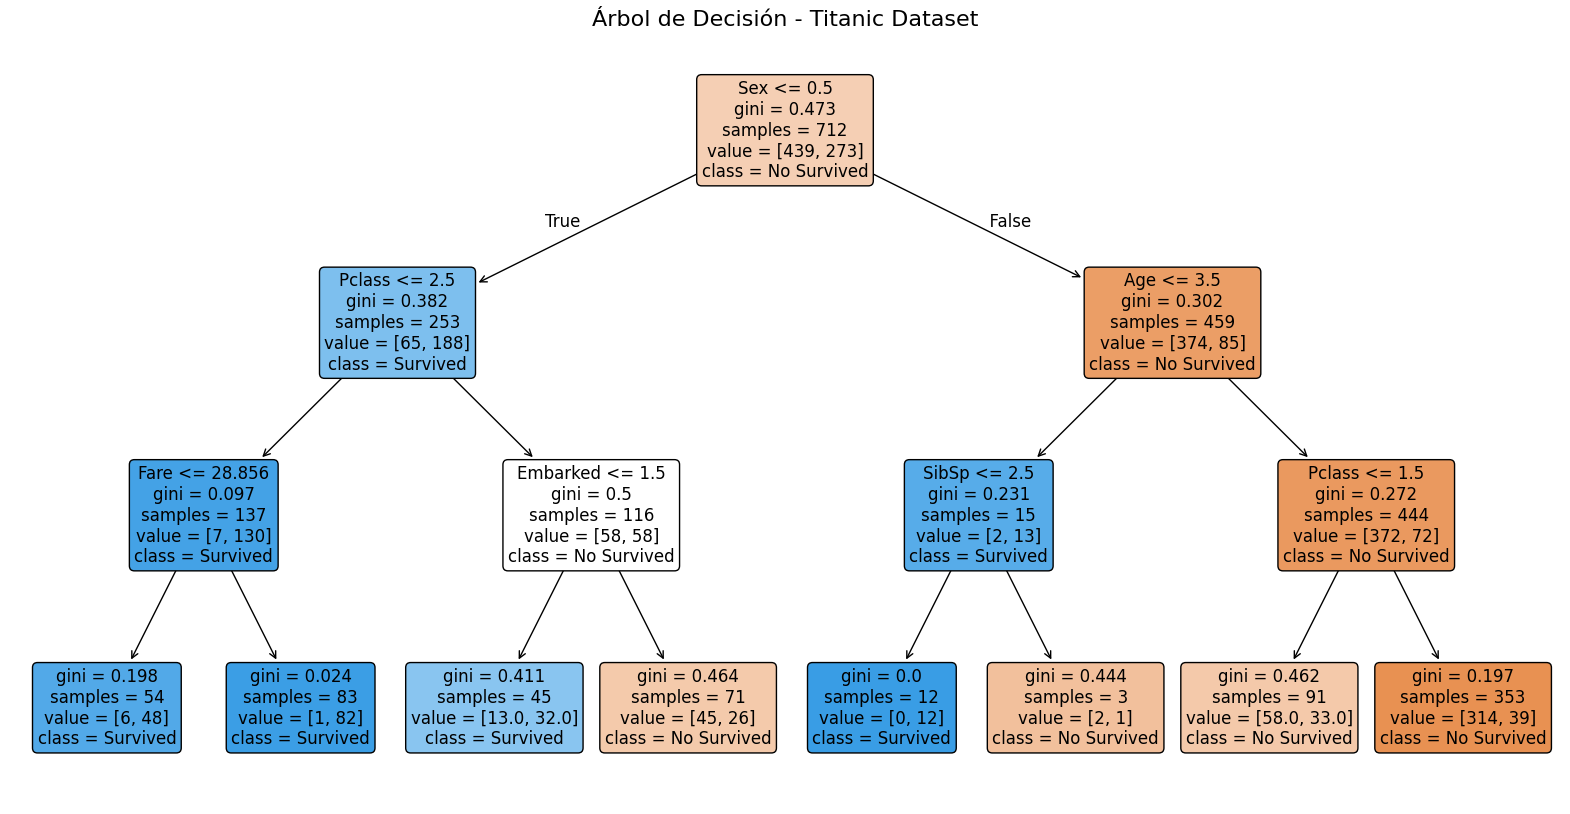

In [14]:
# Visualizar árbol de Titanic
plt.figure(figsize=(20, 10))
plot_tree(dt_titanic,
          feature_names=X_titanic.columns,
          class_names=['No Survived', 'Survived'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title("Árbol de Decisión - Titanic Dataset", fontsize=16)
plt.show()

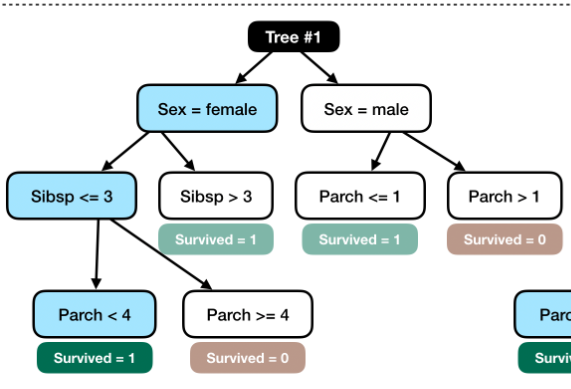

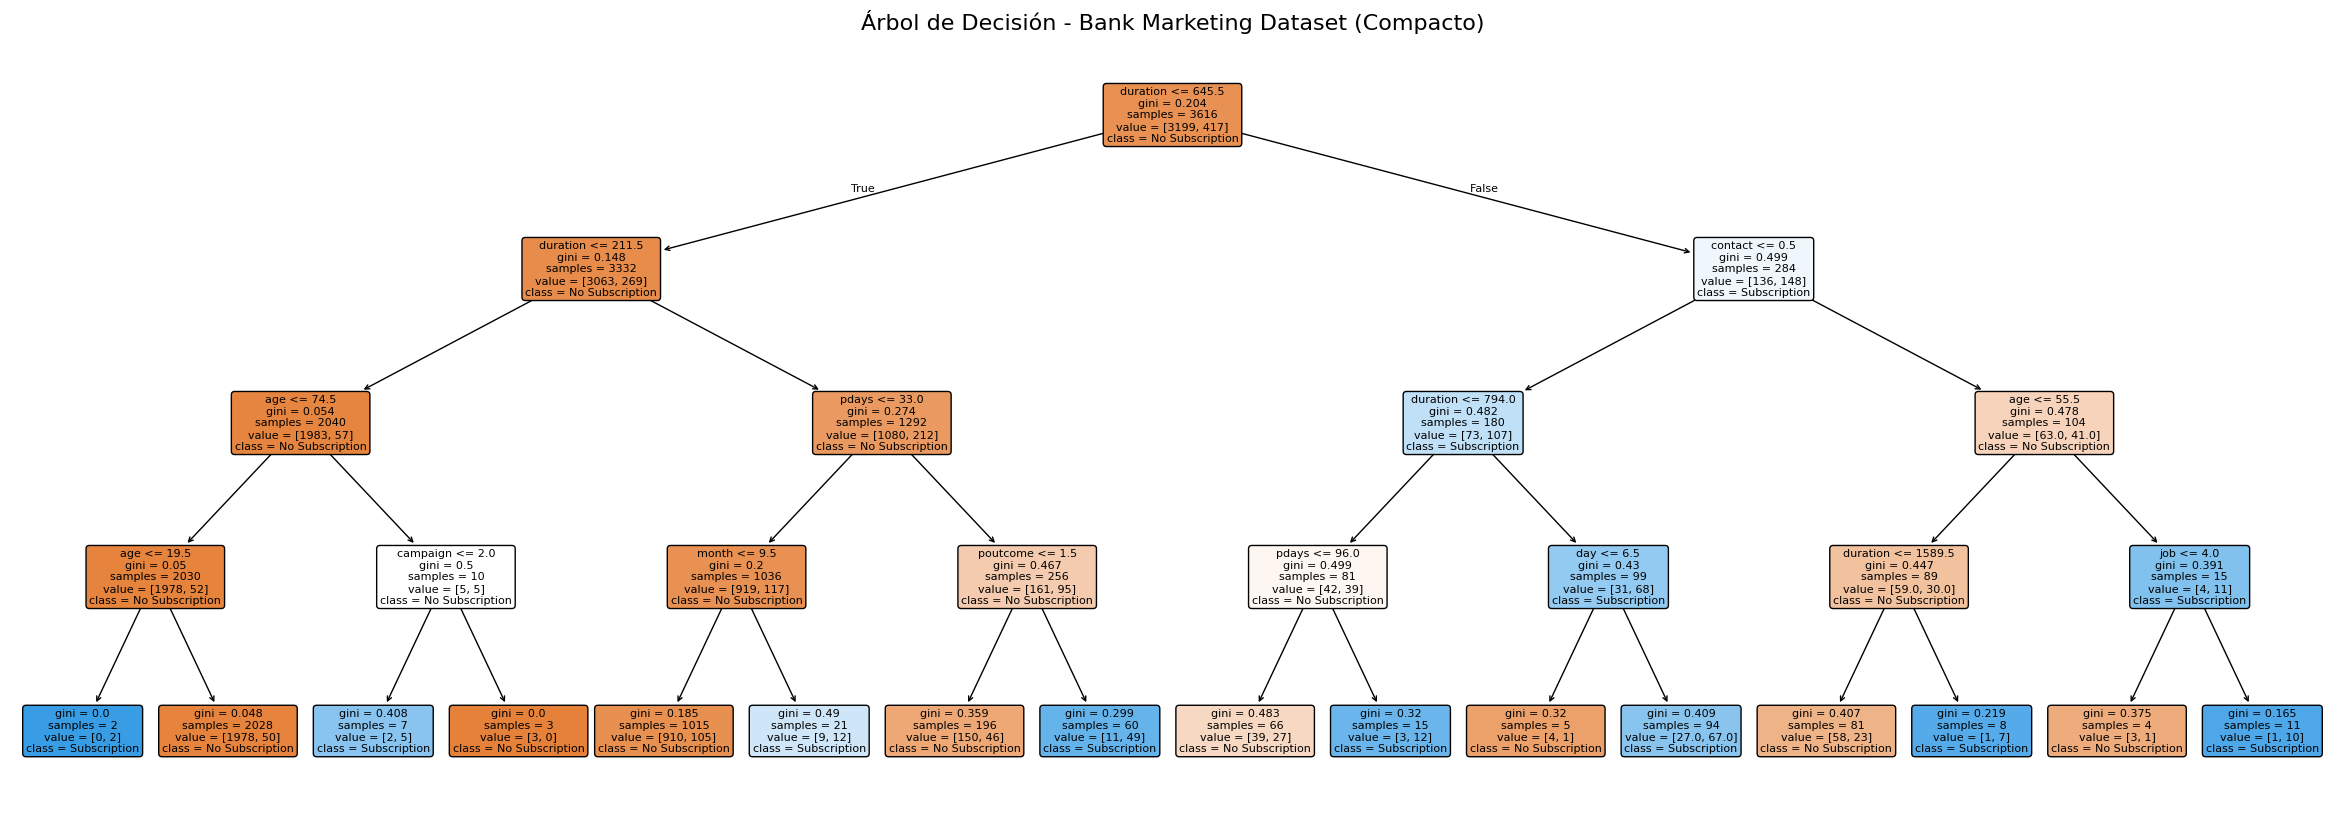

In [21]:
plt.figure(figsize=(30, 10))  # Reduce la altura
plot_tree(dt_bank,
          feature_names=X_bank.columns,
          class_names=['No Subscription', 'Subscription'],
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("Árbol de Decisión - Bank Marketing Dataset (Compacto)", fontsize=16)
plt.show()


## 2.3 Comparación de Criterios de División

In [16]:
# Comparar criterios Gini vs Entropía para Titanic
criterios = ['gini', 'entropy']
results_titanic = {}

for criterio in criterios:
    dt = DecisionTreeClassifier(criterion=criterio, random_state=42, max_depth=5)
    scores = cross_val_score(dt, X_titanic, y_titanic, cv=5, scoring='accuracy')
    results_titanic[criterio] = scores.mean()
    print(f"Titanic - {criterio}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Titanic - gini: 0.8115 (+/- 0.0579)
Titanic - entropy: 0.8114 (+/- 0.0485)


Se compararon los criterios de división Gini y Entropía en un modelo de Árbol de Decisión con validación cruzada de 5 pliegues. Los resultados mostraron un rendimiento casi idéntico entre ambos criterios, con una exactitud promedio cercana al 81%. Esto sugiere que, para el dataset del Titanic, la elección del criterio no influye significativamente en el desempeño del modelo. Por eficiencia computacional, se recomienda mantener el criterio Gini.

In [17]:
# Comparar criterios Gini vs Entropía para Bank Marketing
results_bank = {}

for criterio in criterios:
    dt = DecisionTreeClassifier(criterion=criterio, random_state=42, max_depth=5)
    scores = cross_val_score(dt, X_bank, y_bank, cv=5, scoring='accuracy')
    results_bank[criterio] = scores.mean()
    print(f"Bank Marketing - {criterio}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Bank Marketing - gini: 0.8916 (+/- 0.0213)
Bank Marketing - entropy: 0.8921 (+/- 0.0141)


# 3. Métodos de Ensamble

## 3.1 Random Forest - Bagging

In [ ]:
# Random Forest para Titanic
rf_titanic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_titanic.fit(X_train_t, y_train_t)

y_pred_rf_t = rf_titanic.predict(X_test_t)
accuracy_rf_t = accuracy_score(y_test_t, y_pred_rf_t)

print(f"Random Forest - Titanic - Accuracy: {accuracy_rf_t:.4f}")
print("\nFeature Importances:")
feature_imp_t = pd.DataFrame({
    'feature': X_titanic.columns,
    'importance': rf_titanic.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_imp_t)

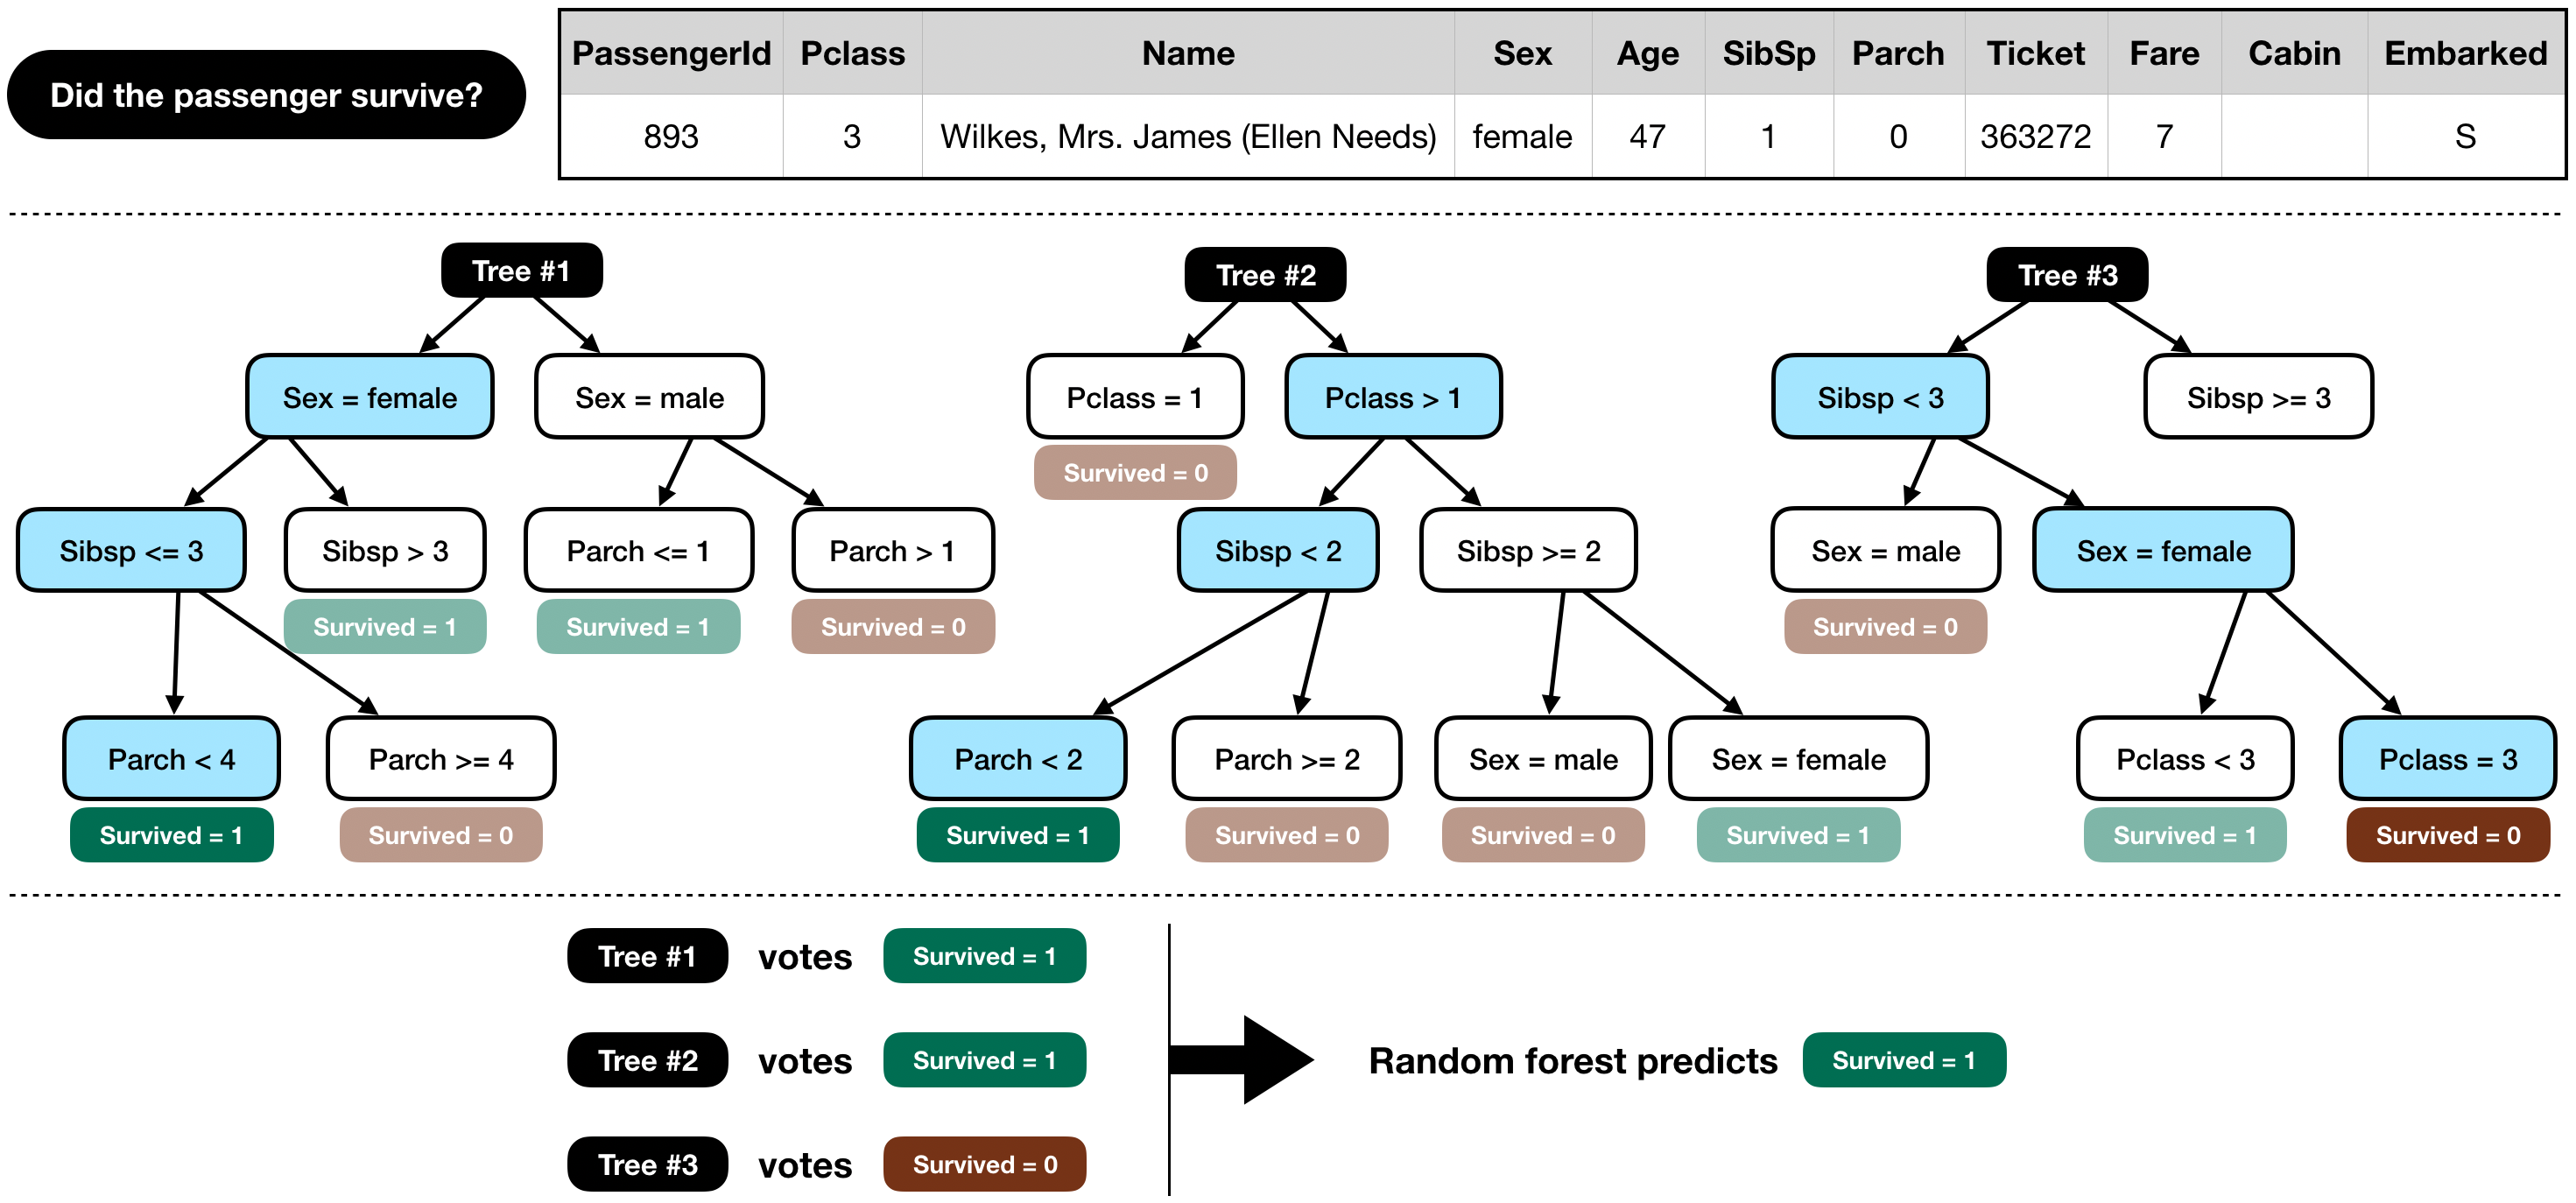

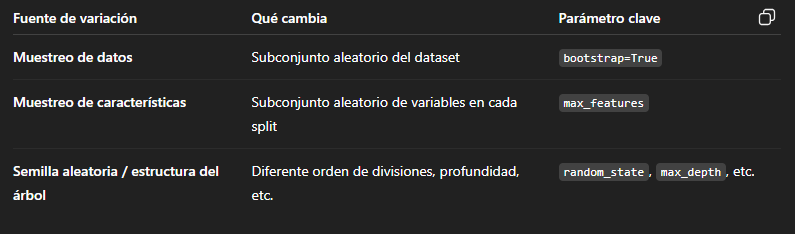

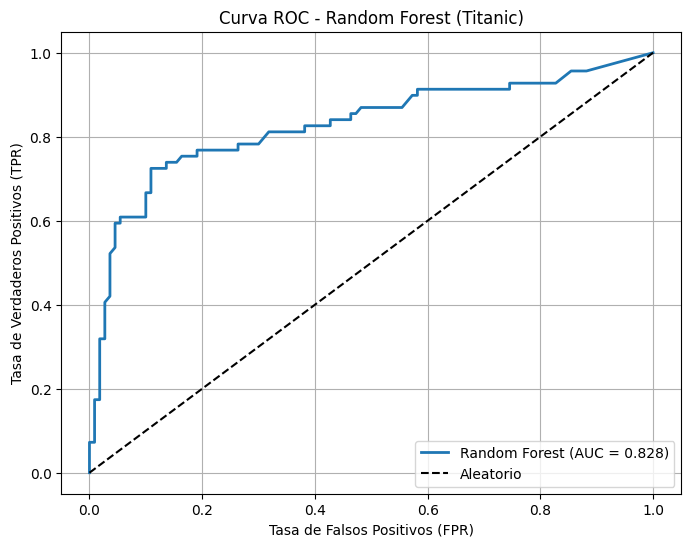

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener las probabilidades de clase positiva
y_prob_rf_t = rf_titanic.predict_proba(X_test_t)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_t, y_prob_rf_t)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.title('Curva ROC - Random Forest (Titanic)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Random Forest para Bank Marketing
rf_bank = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bank.fit(X_train_b, y_train_b)

y_pred_rf_b = rf_bank.predict(X_test_b)
accuracy_rf_b = accuracy_score(y_test_b, y_pred_rf_b)

print(f"Random Forest - Bank Marketing - Accuracy: {accuracy_rf_b:.4f}")
print("\nFeature Importances:")
feature_imp_b = pd.DataFrame({
    'feature': X_bank.columns,
    'importance': rf_bank.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_imp_b)

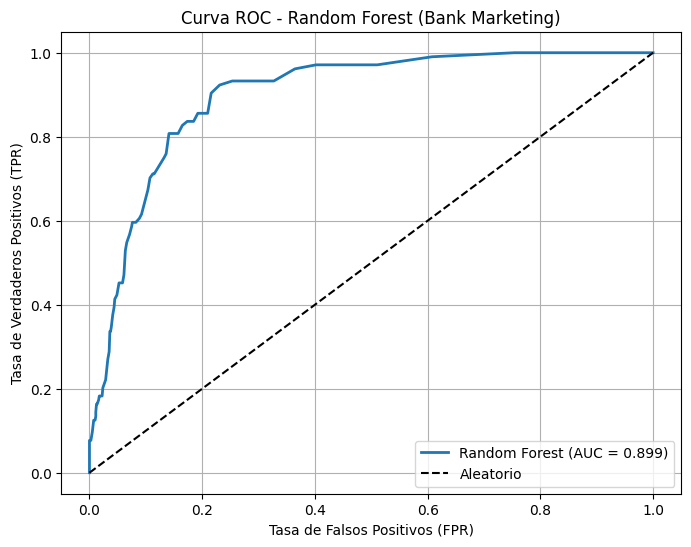

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener las probabilidades de la clase positiva
y_prob_rf_b = rf_bank.predict_proba(X_test_b)[:, 1]

# Calcular la curva ROC
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_prob_rf_b)
roc_auc_b = auc(fpr_b, tpr_b)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, label=f'Random Forest (AUC = {roc_auc_b:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
plt.title('Curva ROC - Random Forest (Bank Marketing)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 3.2 Optimización para Random Forest

In [76]:
# Optimización de Random Forest para Titanic
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10]
}

rf_opt = RandomForestClassifier(random_state=42)
grid_search_t = GridSearchCV(rf_opt, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_t.fit(X_train_t, y_train_t)

print("Mejores parámetros para Titanic:")
print(grid_search_t.best_params_)
print(f"Mejor score: {grid_search_t.best_score_:.4f}")

Mejores parámetros para Titanic:
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Mejor score: 0.8274


In [77]:
# Optimización de Random Forest para Bank Marketing
grid_search_b = GridSearchCV(rf_opt, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_b.fit(X_train_b, y_train_b)

print("Mejores parámetros para Bank Marketing:")
print(grid_search_b.best_params_)
print(f"Mejor score: {grid_search_b.best_score_:.4f}")

Mejores parámetros para Bank Marketing:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Mejor score: 0.9004


## 3.3 Boosting - Gradient Boosting

🌳 Gradient Boosting 

Boosting es una técnica de ensemble learning, es decir, combina varios modelos débiles (por ejemplo, árboles de decisión pequeños) para crear un modelo fuerte.
Los modelos se entrenan de forma secuencial, y cada nuevo modelo trata de corregir los errores del anterior.

¿Por qué se llama Gradient Boosting?

El nombre viene de que el algoritmo minimiza una función de pérdida (loss function) — como el error cuadrático medio — usando gradiente descendente.

En lugar de ajustar pesos (como en redes neuronales), ajusta los árboles para que sigan la dirección del gradiente negativo del error.
Así, cada nuevo árbol “corrige” los errores de los anteriores siguiendo la dirección donde más disminuye la pérdida.

**Parámetros más importantes**

| Parámetro       | Descripción                                                                       |
| --------------- | --------------------------------------------------------------------------------- |
| `n_estimators`  | Número de árboles (iteraciones).                                                  |
| `learning_rate` | Cuánto contribuye cada árbol al modelo final. Valores pequeños = más estabilidad. |
| `max_depth`     | Profundidad máxima de cada árbol (evita sobreajuste).                             |
| `subsample`     | Porcentaje de datos usados por cada árbol (introduce aleatoriedad).               |


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [8]:
# Gradient Boosting para Titanic
gb_titanic = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_titanic.fit(X_train_t, y_train_t)

y_pred_gb_t = gb_titanic.predict(X_test_t)
accuracy_gb_t = accuracy_score(y_test_t, y_pred_gb_t)

print(f"Gradient Boosting - Titanic - Accuracy: {accuracy_gb_t:.4f}")



Gradient Boosting - Titanic - Accuracy: 0.7989


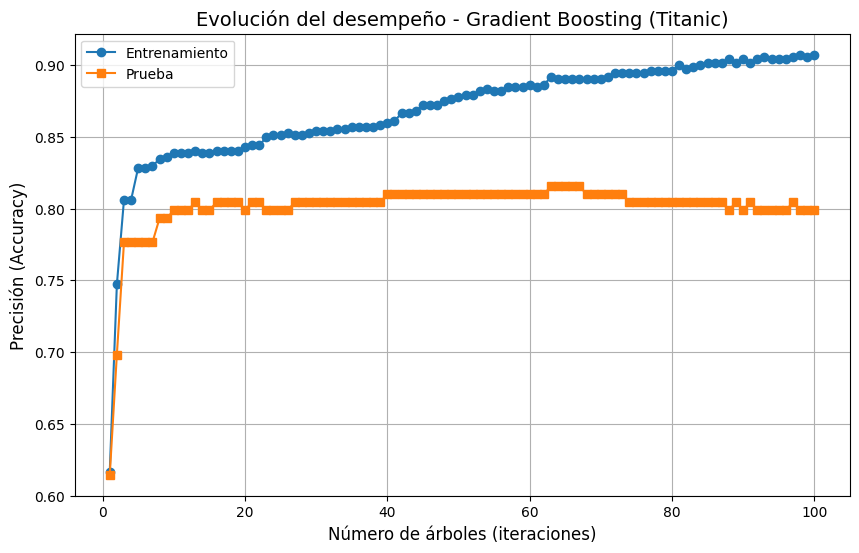

In [13]:
# Entrenamiento del modelo
gb_titanic = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_titanic.fit(X_train_t, y_train_t)

# Calcular precisión en cada iteración usando staged_predict
train_scores = []
test_scores = []

for y_pred_train, y_pred_test in zip(
    gb_titanic.staged_predict(X_train_t),
    gb_titanic.staged_predict(X_test_t)
):
    train_scores.append(accuracy_score(y_train_t, y_pred_train))
    test_scores.append(accuracy_score(y_test_t, y_pred_test))

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(train_scores) + 1), train_scores, label="Entrenamiento", marker='o')
plt.plot(np.arange(1, len(test_scores) + 1), test_scores, label="Prueba", marker='s')

plt.title("Evolución del desempeño - Gradient Boosting (Titanic)", fontsize=14)
plt.xlabel("Número de árboles (iteraciones)", fontsize=12)
plt.ylabel("Precisión (Accuracy)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



El valor de accuracy_gb_t representa qué tan bien el modelo clasifica correctamente a los pasajeros del Titanic en el conjunto de prueba.

El modelo acierta proximadamente 80% de las veces

In [9]:
# Gradient Boosting para Bank Marketing
gb_bank = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_bank.fit(X_train_b, y_train_b)

y_pred_gb_b = gb_bank.predict(X_test_b)
accuracy_gb_b = accuracy_score(y_test_b, y_pred_gb_b)

print(f"Gradient Boosting - Bank Marketing - Accuracy: {accuracy_gb_b:.4f}")

Gradient Boosting - Bank Marketing - Accuracy: 0.8884


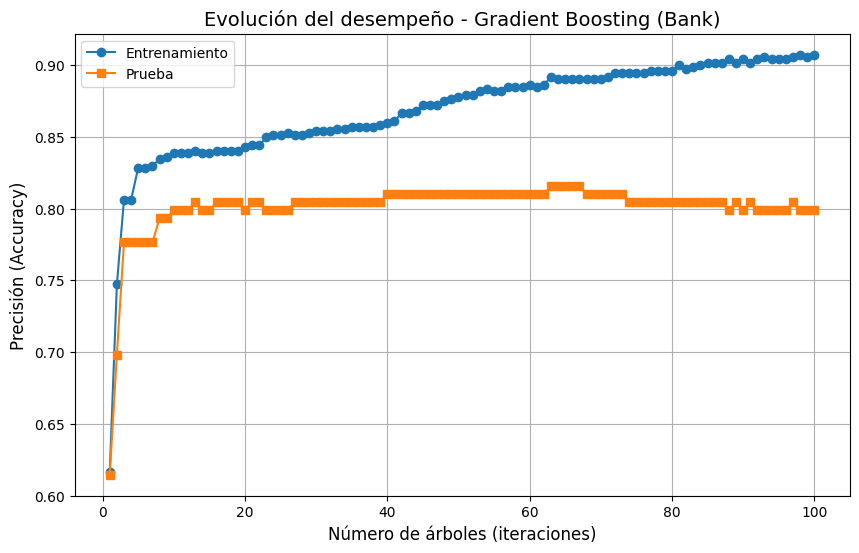

In [15]:
# Entrenamiento del modelo
gb_bank = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_bank.fit(X_train_t, y_train_t)

# Calcular precisión en cada iteración usando staged_predict
train_scores = []
test_scores = []

for y_pred_train, y_pred_test in zip(
    gb_titanic.staged_predict(X_train_t),
    gb_titanic.staged_predict(X_test_t)
):
    train_scores.append(accuracy_score(y_train_t, y_pred_train))
    test_scores.append(accuracy_score(y_test_t, y_pred_test))

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(train_scores) + 1), train_scores, label="Entrenamiento", marker='o')
plt.plot(np.arange(1, len(test_scores) + 1), test_scores, label="Prueba", marker='s')

plt.title("Evolución del desempeño - Gradient Boosting (Bank)", fontsize=14)
plt.xlabel("Número de árboles (iteraciones)", fontsize=12)
plt.ylabel("Precisión (Accuracy)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

El valor de accuracy_gb_t representa qué tan bien el modelo clasifica correctamente a los pasajeros del Titanic en el conjunto de prueba.

El modelo acierta proximadamente 88.8% de las veces

## Opcional

### Boosting - AdaBoost

In [ ]:
# AdaBoost para Titanic
ada_titanic = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
ada_titanic.fit(X_train_t, y_train_t)

y_pred_ada_t = ada_titanic.predict(X_test_t)
accuracy_ada_t = accuracy_score(y_test_t, y_pred_ada_t)

print(f"AdaBoost - Titanic - Accuracy: {accuracy_ada_t:.4f}")

In [ ]:
# AdaBoost para Bank Marketing
ada_bank = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    random_state=42
)
ada_bank.fit(X_train_b, y_train_b)

y_pred_ada_b = ada_bank.predict(X_test_b)
accuracy_ada_b = accuracy_score(y_test_b, y_pred_ada_b)

print(f"AdaBoost - Bank Marketing - Accuracy: {accuracy_ada_b:.4f}")

### Boosting - XGBoost

In [ ]:
# XGBoost para Titanic
xgb_titanic = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_titanic.fit(X_train_t, y_train_t)

y_pred_xgb_t = xgb_titanic.predict(X_test_t)
accuracy_xgb_t = accuracy_score(y_test_t, y_pred_xgb_t)

print(f"XGBoost - Titanic - Accuracy: {accuracy_xgb_t:.4f}")

In [ ]:
# XGBoost para Bank Marketing
xgb_bank = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_bank.fit(X_train_b, y_train_b)

y_pred_xgb_b = xgb_bank.predict(X_test_b)
accuracy_xgb_b = accuracy_score(y_test_b, y_pred_xgb_b)

print(f"XGBoost - Bank Marketing - Accuracy: {accuracy_xgb_b:.4f}")

### Stacking Classifier

In [ ]:
# Stacking Classifier para Titanic
estimators_t = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

stacking_t = StackingClassifier(
    estimators=estimators_t,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_t.fit(X_train_t, y_train_t)
y_pred_stack_t = stacking_t.predict(X_test_t)
accuracy_stack_t = accuracy_score(y_test_t, y_pred_stack_t)

print(f"Stacking Classifier - Titanic - Accuracy: {accuracy_stack_t:.4f}")

In [ ]:
# Stacking Classifier para Bank Marketing
estimators_b = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('xgb', xgb.XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

stacking_b = StackingClassifier(
    estimators=estimators_b,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_b.fit(X_train_b, y_train_b)
y_pred_stack_b = stacking_b.predict(X_test_b)
accuracy_stack_b = accuracy_score(y_test_b, y_pred_stack_b)

print(f"Stacking Classifier - Bank Marketing - Accuracy: {accuracy_stack_b:.4f}")

# 4. Comparación de Modelos

In [ ]:
# Resumen de resultados para Titanic
results_titanic_summary = {
    'Decision Tree': accuracy_t,
    'Random Forest': accuracy_rf_t,
    'Gradient Boosting': accuracy_gb_t,
    'AdaBoost': accuracy_ada_t,
    'XGBoost': accuracy_xgb_t,
    'Stacking': accuracy_stack_t
}

print("COMPARACIÓN DE MODELOS - TITANIC")
print("=" * 40)
for model, accuracy in results_titanic_summary.items():
    print(f"{model:20} | Accuracy: {accuracy:.4f}")

In [ ]:
# Resumen de resultados para Bank Marketing
results_bank_summary = {
    'Decision Tree': accuracy_b,
    'Random Forest': accuracy_rf_b,
    'Gradient Boosting': accuracy_gb_b,
    'AdaBoost': accuracy_ada_b,
    'XGBoost': accuracy_xgb_b,
    'Stacking': accuracy_stack_b
}

print("COMPARACIÓN DE MODELOS - BANK MARKETING")
print("=" * 45)
for model, accuracy in results_bank_summary.items():
    print(f"{model:20} | Accuracy: {accuracy:.4f}")

In [ ]:
# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Titanic
models_t = list(results_titanic_summary.keys())
accuracies_t = list(results_titanic_summary.values())
bars1 = ax1.bar(models_t, accuracies_t, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange', 'pink'])
ax1.set_title('Comparación de Modelos - Titanic', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 1)

# Añadir valores en las barras
for bar, acc in zip(bars1, accuracies_t):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

# Bank Marketing
models_b = list(results_bank_summary.keys())
accuracies_b = list(results_bank_summary.values())
bars2 = ax2.bar(models_b, accuracies_b, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange', 'pink'])
ax2.set_title('Comparación de Modelos - Bank Marketing', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 1)

# Añadir valores en las barras
for bar, acc in zip(bars2, accuracies_b):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 6. Análisis de Importancia de Variables

In [ ]:
# Importancia de variables para Titanic (usando el mejor modelo)
best_rf_t = grid_search_t.best_estimator_
feature_importance_t = pd.DataFrame({
    'feature': X_titanic.columns,
    'importance': best_rf_t.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_t['feature'], feature_importance_t['importance'])
plt.title('Importancia de Variables - Titanic (Random Forest Optimizado)', fontsize=14)
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

In [ ]:
# Importancia de variables para Bank Marketing (usando el mejor modelo)
best_rf_b = grid_search_b.best_estimator_
feature_importance_b = pd.DataFrame({
    'feature': X_bank.columns,
    'importance': best_rf_b.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_b['feature'], feature_importance_b['importance'])
plt.title('Importancia de Variables - Bank Marketing (Random Forest Optimizado)', fontsize=14)
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# 7. Conclusiones

In [ ]:
# Resumen final
print("CONCLUSIONES FINALES")
print("=" * 50)
print("\nTITANIC DATASET:")
print(f"- Mejor modelo: {max(results_titanic_summary, key=results_titanic_summary.get)}")
print(f"- Mejor accuracy: {max(results_titanic_summary.values()):.4f}")
print(f"- Variables más importantes: {list(feature_importance_t.tail(3)['feature'])}")

print("\nBANK MARKETING DATASET:")
print(f"- Mejor modelo: {max(results_bank_summary, key=results_bank_summary.get)}")
print(f"- Mejor accuracy: {max(results_bank_summary.values()):.4f}")
print(f"- Variables más importantes: {list(feature_importance_b.tail(3)['feature'])}")

print("\nOBSERVACIONES GENERALES:")
print("- Los métodos de ensamble generalmente superan a los árboles individuales")
print("- Random Forest y XGBoost suelen ser los métodos más robustos")
print("- La optimización de hiperparámetros puede mejorar significativamente el rendimiento")
print("- La importancia de variables varía según el dataset y el problema específico")